## Environment Setting

In [1]:
!pip install -U torch==1.5 torchvision==0.6 -f https://download.pytorch.org/whl/cu101/torch_stable.html
!pip install cython pyyaml==5.1
!pip install -U 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'
!pip install dominate==2.4.0
!pip install detectron2==0.1.2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/index.html

Looking in links: https://download.pytorch.org/whl/cu101/torch_stable.html
     |████████████████████████████████| 703.8MB 18kB/s 
     |████████████████████████████████| 6.6MB 59.8MB/s 
ERROR: torchtext 0.9.1 has requirement torch==1.8.1, but you'll have torch 1.5.0+cu101 which is incompatible.
  Found existing installation: torch 1.8.1+cu101
    Uninstalling torch-1.8.1+cu101:
      Successfully uninstalled torch-1.8.1+cu101
  Found existing installation: torchvision 0.9.1+cu101
    Uninstalling torchvision-0.9.1+cu101:
      Successfully uninstalled torchvision-0.9.1+cu101
     |████████████████████████████████| 276kB 8.7MB/s 
  Created wheel for pyyaml: filename=PyYAML-5.1-cp37-cp37m-linux_x86_64.whl size=44074 sha256=cf278d72cbc6a7e30aad9a426f246c882007ddb5b65f59330e10aff7a980ff50
  Stored in directory: /root/.cache/pip/wheels/ad/56/bc/1522f864feb2a358ea6f1a92b4798d69ac783a28e80567a18b
Successfully built pyyaml
  Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.1

## Clone the file from Gihub

In [2]:
!git clone https://github.com/ericsujw/InstColorization.git

Cloning into 'InstColorization'...
remote: Enumerating objects: 211, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (2/2), done.
remote: Total 211 (delta 0), reused 2 (delta 0), pack-reused 208
Receiving objects: 100% (211/211), 6.11 MiB | 4.70 MiB/s, done.
Resolving deltas: 100% (78/78), done.


## Start Colorization

In [3]:
cd InstColorization/

/content/InstColorization


## Download the Model

In [4]:
!sh scripts/download_model.sh

Downloading...
Finish download.
Archive:  checkpoints.zip
   creating: checkpoints/coco_finetuned_mask_256_ffs/
  inflating: checkpoints/coco_finetuned_mask_256_ffs/latest_net_GComp.pth  
  inflating: checkpoints/coco_finetuned_mask_256_ffs/latest_net_G.pth  
  inflating: checkpoints/coco_finetuned_mask_256_ffs/latest_net_GF.pth  
   creating: checkpoints/coco_finetuned_mask_256/
  inflating: checkpoints/coco_finetuned_mask_256/latest_net_GComp.pth  
  inflating: checkpoints/coco_finetuned_mask_256/latest_net_G.pth  
  inflating: checkpoints/coco_finetuned_mask_256/latest_net_GF.pth  
   creating: checkpoints/siggraph_retrained/
  inflating: checkpoints/siggraph_retrained/latest_net_G.pth  


### Detect Object bounding box


Setting the Detectron2.

In [6]:
from os.path import join, isfile, isdir
from os import listdir
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
from argparse import ArgumentParser

import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

import numpy as np
import cv2

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg

import torch

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_X_101_32x8d_FPN_3x.yaml"))
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_X_101_32x8d_FPN_3x.yaml")
predictor = DefaultPredictor(cfg)

Let's create a bounding box folder to save our prediction results.

In [7]:
input_dir = "example"
image_list = [f for f in listdir(input_dir) if isfile(join(input_dir, f))]
output_npz_dir = "{0}_bbox".format(input_dir)
if os.path.isdir(output_npz_dir) is False:
    print('Create path: {0}'.format(output_npz_dir))
    os.makedirs(output_npz_dir)

Create path: example_bbox


Here we simply take L channel as our input and make sure that we can get consistent box prediction results even though the original image is color images.

In [8]:
for image_path in image_list:
    img = cv2.imread(join(input_dir, image_path))
    lab_image = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
    l_channel, a_channel, b_channel = cv2.split(lab_image)
    l_stack = np.stack([l_channel, l_channel, l_channel], axis=2)
    outputs = predictor(l_stack)
    save_path = join(output_npz_dir, image_path.split('.')[0])
    pred_bbox = outputs["instances"].pred_boxes.to(torch.device('cpu')).tensor.numpy()
    pred_scores = outputs["instances"].scores.cpu().data.numpy()
    np.savez(save_path, bbox = pred_bbox, scores = pred_scores)

Now we have all the images' prediction results.

In [9]:
!ls example_bbox

000000022969.npz  574100c6e31a1dcd096476eb2d632b3c.npz
000000023781.npz  8b01a894fb91025a1dc77611838e9d13.npz
000000046872.npz  925f179ba736e15e89bfd6d88e0bba56.npz
000000050145.npz  e9b6826aa623549ec77bbc0275002779.npz


### Colorize Images

We first set up some libraries and options

In [10]:
import sys
import time
from options.train_options import TestOptions
from models import create_model

import torch
from tqdm import tqdm_notebook

from fusion_dataset import Fusion_Testing_Dataset
from util import util
import multiprocessing
multiprocessing.set_start_method('spawn', True)

torch.backends.cudnn.benchmark = True

sys.argv = [sys.argv[0]]
opt = TestOptions().parse()


#The import below are necessary for Seam Carving
import cv2
import numpy as np
from imageio import imread, imwrite
from scipy.ndimage.filters import convolve
from matplotlib import pyplot as plt




Then we need to create a results folder to save our predicted color images and read the dataset loader.

In [11]:
save_img_path = opt.results_img_dir
if os.path.isdir(save_img_path) is False:
    print('Create path: {0}'.format(save_img_path))
    os.makedirs(save_img_path)
opt.batch_size = 1
dataset = Fusion_Testing_Dataset(opt, -1)
dataset_loader = torch.utils.data.DataLoader(dataset, batch_size=opt.batch_size)

dataset_size = len(dataset)
print('#Testing images = %d' % dataset_size)

Create path: results
#Testing images = 8


Load the pre-trained model.

In [12]:
model = create_model(opt)
model.setup_to_test('coco_finetuned_mask_256_ffs')

initialize network with normal
initialize network with normal
initialize network with normal
model [FusionModel] was created
load Fusion model from checkpoints/coco_finetuned_mask_256_ffs/latest_net_GF.pth


In [35]:
cd ..

/content/InstColorization


Start to colorize every images in `dataset_loader`.

In [36]:
count_empty = 0
for data_raw in tqdm_notebook(dataset_loader):
    data_raw['full_img'][0] = data_raw['full_img'][0].cuda()
    if data_raw['empty_box'][0] == 0:
        data_raw['cropped_img'][0] = data_raw['cropped_img'][0].cuda()
        box_info = data_raw['box_info'][0]
        box_info_2x = data_raw['box_info_2x'][0]
        box_info_4x = data_raw['box_info_4x'][0]
        box_info_8x = data_raw['box_info_8x'][0]
        cropped_data = util.get_colorization_data(data_raw['cropped_img'], opt, ab_thresh=0, p=opt.sample_p)
        full_img_data = util.get_colorization_data(data_raw['full_img'], opt, ab_thresh=0, p=opt.sample_p)
        model.set_input(cropped_data)
        model.set_fusion_input(full_img_data, [box_info, box_info_2x, box_info_4x, box_info_8x])
        model.forward()
    else:
        count_empty += 1
        full_img_data = util.get_colorization_data(data_raw['full_img'], opt, ab_thresh=0, p=opt.sample_p)
        model.set_forward_without_box(full_img_data)
    model.save_current_imgs(join(save_img_path, data_raw['file_id'][0] + '.png'))
print('{0} images without bounding boxes'.format(count_empty))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:2973: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))



0 images without bounding boxes


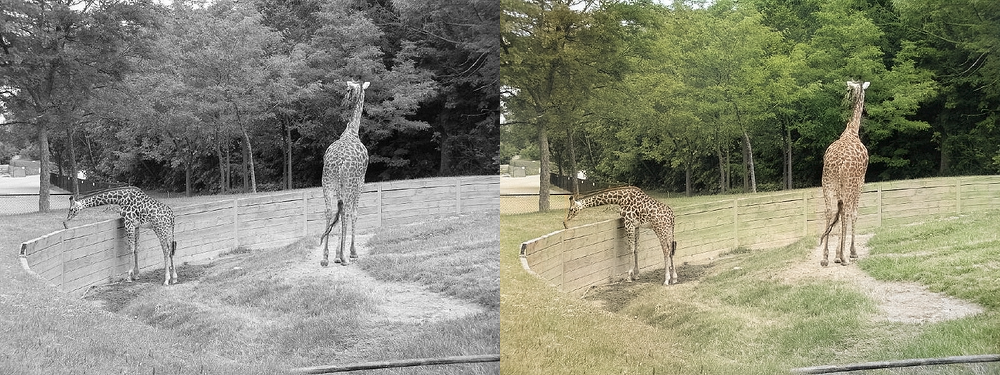

In [37]:
from google.colab.patches import cv2_imshow
img_name_list = ['000000022969', '000000023781', '000000046872', '000000050145']
show_index = 0

img = cv2.imread('example/'+img_name_list[show_index]+'.jpg')
lab_image = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
l_channel, _, _ = cv2.split(lab_image)

img = cv2.imread('results/'+img_name_list[show_index]+'.png')
lab_image = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
_, a_pred, b_pred = cv2.split(lab_image)
a_pred = cv2.resize(a_pred, (l_channel.shape[1], l_channel.shape[0]))
b_pred = cv2.resize(b_pred, (l_channel.shape[1], l_channel.shape[0]))
gray_color = np.ones_like(a_pred) * 128

gray_image = cv2.cvtColor(np.stack([l_channel, gray_color, gray_color], 2), cv2.COLOR_LAB2BGR)
color_image = cv2.cvtColor(np.stack([l_channel, a_pred, b_pred], 2), cv2.COLOR_LAB2BGR)

# save_img_path = 'results_origin/'
# if os.path.isdir(save_img_path) is False:
#     print('Create path: {0}'.format(save_img_path))
#     os.makedirs(save_img_path)

# cv2.imwrite('results_origin/'+img_name_list[show_index]+'.png', color_image)
# newcolor_image = np.float32(color_image)
# drawn_image =  cv2.cvtColor(color_image, cv2.COLOR_BGR2RGB)
# cv2.imwrite('image_name,  drawn_image)

cv2_imshow(np.concatenate([gray_image, color_image], 1))

In [39]:
      # drawn_image = np.float32(drawn_image)
      # drawn_image =  cv2.cvtColor(drawn_image, cv2.COLOR_BGR2RGB)
      # cv2.imwrite(image_name,  drawn_image)
img_name = ['000000022969', '000000023781', '000000046872', '000000050145']
i = 0
cv2.imread('results/'+img_name[i]+'.png')

array([[[ 75, 113, 108],
        [ 98, 133, 132],
        [ 87, 122, 120],
        ...,
        [ 48,  80,  66],
        [ 56,  89,  75],
        [ 52,  82,  73]],

       [[ 63, 102,  98],
        [102, 136, 132],
        [ 90, 127, 123],
        ...,
        [ 61,  93,  81],
        [ 55,  86,  74],
        [ 45,  72,  62]],

       [[ 70, 103, 102],
        [ 71, 101, 101],
        [ 73, 106, 104],
        ...,
        [ 50,  80,  69],
        [ 49,  76,  66],
        [ 53,  78,  67]],

       ...,

       [[101, 147, 159],
        [104, 152, 163],
        [113, 162, 173],
        ...,
        [107, 128, 119],
        [ 99, 122, 114],
        [113, 139, 131]],

       [[ 98, 144, 154],
        [107, 154, 166],
        [126, 171, 181],
        ...,
        [103, 124, 115],
        [ 98, 122, 115],
        [119, 143, 136]],

       [[ 97, 146, 155],
        [100, 150, 162],
        [110, 158, 169],
        ...,
        [114, 136, 128],
        [ 99, 121, 114],
        [111, 135, 128]]

In [18]:
cd example/

/content/InstColorization/example


In [19]:
ls

000000022969.jpg*  574100c6e31a1dcd096476eb2d632b3c.jpg
000000023781.jpg*  8b01a894fb91025a1dc77611838e9d13.jpg
000000046872.jpg*  925f179ba736e15e89bfd6d88e0bba56.jpg
000000050145.jpg*  e9b6826aa623549ec77bbc0275002779.jpg


In [21]:
#This is the part where Seam Carving implementation
# MAIN FUNCTIONS
import skimage.io
def load_image(path):
  """
  Parameters:
  path: String representing relative/absolute path to the image file

  Output: Numpy array of shape (width, height, channels)
  """
  return cv2.imread(path).astype(np.float32)

def image_rotate(image, clockwise):
    value = 1 if clockwise else 3
    return np.rot90(image, value) 



def getBrightness(image):
  """
  Parameters:
  image: Numpy array of shape (width, height)

  Output: 2D numpy array where each coordinate's value represents the average across the input 
  image's channels at that coordinate
  """
  width, height, channels = image.shape
  output = np.zeros((width, height))
  for w in range(width):
    for h in range(height):
      total_across_channels = 0
      for c in range(channels):
        total_across_channels += image[w][h][c]
      output[w][h] = int(total_across_channels/channels)
  return output

def computeEnergy(image):
    """
    Computes the energy of an image
    """
    image = image.astype('float32')
    sobel_x =  np.array([
        [1.0, 0.0, -1.0],
        [2.0, 0.0, -2.0],
        [1.0, 0.0, -1.0],
    ])

    sobel_y = np.array([
        [1.0, 2.0, 1.0],
        [0.0, 0.0, 0.0],
        [-1.0, -2.0, -1.0],
    ])

    filter_x = np.stack([sobel_x]*3, axis=2)
    filter_y = np.stack([sobel_y]*3, axis=2)

    filtered = np.absolute(convolve(image, filter_x)) + np.absolute(convolve(image, filter_x))

    energy = filtered.sum(axis=2)

    return energy


def seamEnergyMap(image):
  width, height, channels = image.shape
  image_energy_map = computeEnergy(image)
  min_cumulative_energy = image_energy_map[: , :]
  direction = np.zeros((width, height), dtype=np.int)

  for x in range(1, width):
    for y in range(0, height):
      min_val = 0
      if y == 0:
        index = np.argmin(min_cumulative_energy[x-1, y:y+2])
        direction[x, y] = index + y
        min_val = min_cumulative_energy[x-1,  index + y]
      else:
        index = np.argmin(min_cumulative_energy[x-1, y-1:y+2])
        direction[x, y] = index + y - 1
        min_val = min_cumulative_energy[x-1,  index + y - 1]
      
      min_cumulative_energy[x,y] += min_val
  
  return min_cumulative_energy, direction


def seamIndex(image):
    width, height, channels = image.shape
    min_cumulative_energy, direction = seamEnergyMap(image)
    minSeamEnergyIndex = np.argmin(min_cumulative_energy[-1])
    seamIndexList = [0] * width
    seamIndexList[width-1] = minSeamEnergyIndex
    for i in range(width-1, -1, -1):
      minSeamEnergyIndex = direction[i, minSeamEnergyIndex]
      seamIndexList[i] = minSeamEnergyIndex
    return seamIndexList


def addSeam(image, seamIndex):
    rows, cols, channels = image.shape
    result = np.zeros((rows, cols + 1, channels))
    for r in range(rows):
      col = seamIndex[r]
      for c in range(channels):
        if col == 0:
          result[r, col, c] = image[r, col, c]
          result[r, col + 1, c] = np.average(image[r, col: col+2, c])
          result[r, col+2:, c] = image[r, col+1:, c]
        else:
          result[r, :col, c] = image[r, :col, c]
          result[r, col, c] = np.average(image[r, col-1: col+1, c])
          result[r, col+1:, c] = image[r, col:, c]
    return result



def reduceImageColumns(image, scale):
    width, height, channels = image.shape
    reduced_columns = int(height - scale*height)
    temp_image = image.copy()
    for i in range(reduced_columns):
      temp_image, drawn_image = removeColumn(temp_image)
      image_name = "./r" + str(i).zfill(3) +".jpg"
      drawn_image = np.float32(drawn_image)
      drawn_image =  cv2.cvtColor(drawn_image, cv2.COLOR_BGR2RGB)
      cv2.imwrite(image_name,  drawn_image)
      # new_drawn_image = skimage.io.imread(image_name)
      # cv2.imwrite(image_name, cv2.cvtColor(new_drawn_image, cv2.COLOR_RGB2BGR))
    return temp_image



# Optimize by reusing seamIndex function to find seam
def removeColumn(image):
  new_im = image * 1.0
  width, height, channels = image.shape
  min_cumulative_energy, direction = seamEnergyMap(image)
  removableElements = np.ones((width, height), dtype=np.bool)
  seam_index = [0]*width
  minSeamEnergyIndex = np.argmin(min_cumulative_energy[-1])
  seam_index[-1]  = minSeamEnergyIndex
  for i in range(width-1, -1, -1):
    removableElements[i, minSeamEnergyIndex] = False
    minSeamEnergyIndex = direction[i, minSeamEnergyIndex]
    seam_index[i] = minSeamEnergyIndex
  drawn_image = draw_seams(image * 1.0, seam_index)
  removableElements = np.stack([removableElements] * 3, axis=2)
  return image[removableElements].reshape((width, height-1, channels)), drawn_image

def reduceImageRows(image, scale):
  return np.rot90(reduceImageColumns(np.rot90(image, 1, (0,1)), scale), 3, (0,1))

def image_transpose(image):
      width, height, channels = image.shape
      return np.transpose(image, (1, 0, 2))

def seam_carving2D(image, scaleX, scaleY):
    return reduceImageColumns(reduceImageRows(image, scaleY), scaleX)



def enlarge(image, scale):
    rows, cols, channels = image.shape    
    if scale < 1:
      print("Invalid argument: Scale needs to be greater than / equal to 1 for enlargement")
    elif scale == 1:
      return image
    else:
      enlarged_im, reduced_output, new_im = image * 1.0, image * 1.0, image * 1.0
      steps = int(scale * cols - cols)
      while steps > 0:
        seam = seamIndex(reduced_output)
        enlarged_im = addSeam(enlarged_im, seam)
        reduced_output, drawn_image = removeColumn(reduced_output)
        steps -= 1
    return enlarged_im

def enlarge2D(image, scale_X, scale_Y):
    rows, cols, channels = image.shape
    if (scale_X <= 1 or scale_Y <= 1):
      print ("Invalid argument: Scale needs to be greater than / equal to 1 for enlargement")
      return
    else:
      enlarged_X = enlarge(image, scale_X)
      transpose_enlargedX = image_transpose(enlarged_X);
      enlargedX_Y = enlarge(transpose_enlargedX, scale_Y);
      return image_transpose(enlargedX_Y);



def draw_seams(im, seam):
  width, height, channels = im.shape
  for j in range(0, width):
    im[j, seam[j], 0] = 255
    im[j, seam[j], 1] = 0
    im[j, seam[j], 2] = 0

  return im


# MAIN FUNCTIONS
import skimage.io
def load_image(path):
  """
  Parameters:
  path: String representing relative/absolute path to the image file

  Output: Numpy array of shape (width, height, channels)
  """
  return cv2.imread(path).astype(np.float32)

def image_rotate(image, clockwise):
    value = 1 if clockwise else 3
    return np.rot90(image, value) 



def getBrightness(image):
  """
  Parameters:
  image: Numpy array of shape (width, height)

  Output: 2D numpy array where each coordinate's value represents the average across the input 
  image's channels at that coordinate
  """
  width, height, channels = image.shape
  output = np.zeros((width, height))
  for w in range(width):
    for h in range(height):
      total_across_channels = 0
      for c in range(channels):
        total_across_channels += image[w][h][c]
      output[w][h] = int(total_across_channels/channels)
  return output

def computeEnergy(image):
    image = image.astype('float32')
    sobel_x =  np.array([
        [1.0, 0.0, -1.0],
        [2.0, 0.0, -2.0],
        [1.0, 0.0, -1.0],
    ])

    sobel_y = np.array([
        [1.0, 2.0, 1.0],
        [0.0, 0.0, 0.0],
        [-1.0, -2.0, -1.0],
    ])

    filter_x = np.stack([sobel_x]*3, axis=2)
    filter_y = np.stack([sobel_y]*3, axis=2)

    filtered = np.absolute(convolve(image, filter_x)) + np.absolute(convolve(image, filter_x))

    energy = filtered.sum(axis=2)

    return energy


def seamEnergyMap(image):
  width, height, channels = image.shape
  image_energy_map = computeEnergy(image)
  min_cumulative_energy = image_energy_map[: , :]
  direction = np.zeros((width, height), dtype=np.int)

  for x in range(1, width):
    for y in range(0, height):
      min_val = 0
      if y == 0:
        index = np.argmin(min_cumulative_energy[x-1, y:y+2])
        direction[x, y] = index + y
        min_val = min_cumulative_energy[x-1,  index + y]
      else:
        index = np.argmin(min_cumulative_energy[x-1, y-1:y+2])
        direction[x, y] = index + y - 1
        min_val = min_cumulative_energy[x-1,  index + y - 1]
      
      min_cumulative_energy[x,y] += min_val
  
  return min_cumulative_energy, direction


def seamIndex(image):
    width, height, channels = image.shape
    min_cumulative_energy, direction = seamEnergyMap(image)
    minSeamEnergyIndex = np.argmin(min_cumulative_energy[-1])
    seamIndexList = [0] * width
    seamIndexList[width-1] = minSeamEnergyIndex
    for i in range(width-1, -1, -1):
      minSeamEnergyIndex = direction[i, minSeamEnergyIndex]
      seamIndexList[i] = minSeamEnergyIndex
    return seamIndexList


def addSeam(image, seamIndex):
    rows, cols, channels = image.shape
    result = np.zeros((rows, cols + 1, channels))
    for r in range(rows):
      col = seamIndex[r]
      for c in range(channels):
        if col == 0:
          result[r, col, c] = image[r, col, c]
          result[r, col + 1, c] = np.average(image[r, col: col+2, c])
          result[r, col+2:, c] = image[r, col+1:, c]
        else:
          result[r, :col, c] = image[r, :col, c]
          result[r, col, c] = np.average(image[r, col-1: col+1, c])
          result[r, col+1:, c] = image[r, col:, c]
    return result



def reduceImageColumns(image, scale):
    width, height, channels = image.shape
    reduced_columns = int(height - scale*height)
    temp_image = image.copy()
    for i in range(reduced_columns):
      temp_image, drawn_image = removeColumn(temp_image)
      image_name = "./r" + str(i).zfill(3) +".jpg"
      drawn_image = np.float32(drawn_image)
      drawn_image =  cv2.cvtColor(drawn_image, cv2.COLOR_BGR2RGB)
      cv2.imwrite(image_name,  drawn_image)
      # new_drawn_image = skimage.io.imread(image_name)
      # cv2.imwrite(image_name, cv2.cvtColor(new_drawn_image, cv2.COLOR_RGB2BGR))
    return temp_image



# Optimize by reusing seamIndex function to find seam
def removeColumn(image):
  new_im = image * 1.0
  width, height, channels = image.shape
  min_cumulative_energy, direction = seamEnergyMap(image)
  removableElements = np.ones((width, height), dtype=np.bool)
  seam_index = [0]*width
  minSeamEnergyIndex = np.argmin(min_cumulative_energy[-1])
  seam_index[-1]  = minSeamEnergyIndex
  for i in range(width-1, -1, -1):
    removableElements[i, minSeamEnergyIndex] = False
    minSeamEnergyIndex = direction[i, minSeamEnergyIndex]
    seam_index[i] = minSeamEnergyIndex
  drawn_image = draw_seams(image * 1.0, seam_index)
  removableElements = np.stack([removableElements] * 3, axis=2)
  return image[removableElements].reshape((width, height-1, channels)), drawn_image

def reduceImageRows(image, scale):
  return np.rot90(reduceImageColumns(np.rot90(image, 1, (0,1)), scale), 3, (0,1))

def image_transpose(image):
      width, height, channels = image.shape
      return np.transpose(image, (1, 0, 2))

def seam_carving(image, resolution):
    return

def seam_carving2D(image, scaleX, scaleY):
    return reduceImageColumns(reduceImageRows(image, scaleY), scaleX)



def enlarge(image, scale):
    rows, cols, channels = image.shape    
    if scale < 1:
      print("Invalid argument: Scale needs to be greater than / equal to 1 for enlargement")
    elif scale == 1:
      return image
    else:
      enlarged_im, reduced_output, new_im = image * 1.0, image * 1.0, image * 1.0
      steps = int(scale * cols - cols)
      while steps > 0:
        seam = seamIndex(reduced_output)
        enlarged_im = addSeam(enlarged_im, seam)
        reduced_output, drawn_image = removeColumn(reduced_output)
        steps -= 1
    return enlarged_im

def enlarge2D(image, scale_X, scale_Y):
    rows, cols, channels = image.shape
    if (scale_X <= 1 or scale_Y <= 1):
      print ("Invalid argument: Scale needs to be greater than / equal to 1 for enlargement")
      return
    else:
      enlarged_X = enlarge(image, scale_X)
      transpose_enlargedX = image_transpose(enlarged_X);
      enlargedX_Y = enlarge(transpose_enlargedX, scale_Y);
      return image_transpose(enlargedX_Y);



def draw_seams(im, seam):
  width, height, channels = im.shape
  for j in range(0, width):
    im[j, seam[j], 0] = 255
    im[j, seam[j], 1] = 0
    im[j, seam[j], 2] = 0

  return im







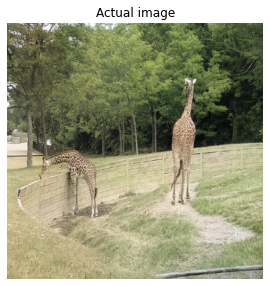

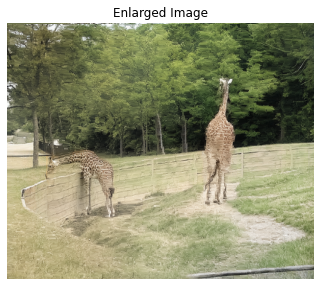

In [50]:
# TESTING

import matplotlib as mpl
def display_image_in_actual_size(im, title = ""):
#This function was directly sourced from: https://rb.gy/nbkluq
    dpi = mpl.rcParams['figure.dpi']
    # im_data = plt.imread(im_path)
    im_data = im
    height, width, depth = im_data.shape

    # What size does the figure need to be in inches to fit the image?
    figsize = width / float(dpi), height / float(dpi)

    # Create a figure of the right size with one axes that takes up the full figure
    fig = plt.figure(figsize=figsize)
    ax = fig.add_axes([0, 0, 1, 1])

    # Hide spines, ticks, etc.
    ax.axis('off')

    # Display the image.
    ax.imshow(im_data)

    plt.title(title)

    plt.show()








im_list = [cv2.imread('example/000000022969.jpg'), 
           cv2.imread('example/574100c6e31a1dcd096476eb2d632b3c.jpg'), 
           cv2.imread('example/8b01a894fb91025a1dc77611838e9d13.jpg'), 
           cv2.imread('example/000000046872.jpg'),
           cv2.imread('example/925f179ba736e15e89bfd6d88e0bba56.jpg'),
           cv2.imread('example/000000050145.jpg'),
           cv2.imread('example/e9b6826aa623549ec77bbc0275002779.jpg')
           ]


im = [cv2.cvtColor(im_list[i], cv2.COLOR_RGB2BGR) for i in range(len(im_list))]

# plt.imshow(im[5])


def test_drawseam():
  display_image_in_actual_size(im[-1])
  seams = seamIndex(im[-1])
  display_image_in_actual_size(draw_seams(im[-1], seams))
  energy_image = reduceImageColumns(im[-1], 0.98)
  seams = seamIndex(energy_image)
  display_image_in_actual_size(draw_seams(energy_image, seams))

def test_imagerotate():
  display_image_in_actual_size(im[0])
  rotated_im = image_rotate(im[0], True)
  display_image_in_actual_size(rotated_im)

def testEnergy():
    # fig = plt.figure(figsize=(10, 7))
    display_image_in_actual_size(im[0])
    energy_image = computeEnergy(im[0])
    display_image_in_actual_size(energy_image)

    return


def test_transpose():
    display_image_in_actual_size(im[0], "Actual image")
    transpose_image = image_transpose(im[0])
    display_image_in_actual_size(transpose_image, "Transposed Image")
    return

# def testSeamCarving_2D():
#     return

def testReduceColumns(scale):
    display_image_in_actual_size(im[-1], "Actual image")
    energy_image = reduceImageColumns(im[-1], scale)
    display_image_in_actual_size(energy_image, "")
    return


def testDisplayImage():
  img_name = ['000000022969', '000000023781', '000000046872', '000000050145']
  i = 0
  im_result = np.float32(cv2.imread('results/'+img_name[i]+'.png'))
  final_im = cv2.cvtColor(im_result, cv2.COLOR_RGB2BGR)
  display_image_in_actual_size(final_im/255)
  # display_image_in_actual_size(im[0])
  # new_im = cv2.cvtColor(im[0], cv2.COLOR_RGB2BGR)
  # display_image_in_actual_size(new_im)


def testEnlarge():
    img_name = ['000000022969', '000000023781', '000000046872', '000000050145']
    i = 0
    im_result = np.float32(cv2.imread('results/'+img_name[i]+'.png'))
    final_im = cv2.cvtColor(im_result, cv2.COLOR_RGB2BGR)
    display_image_in_actual_size(final_im/255, "Actual image")
    enlarged_image = enlarge(final_im, 1.2)
    display_image_in_actual_size(enlarged_image/255, "Enlarged Image")
    return

def testEnlarge2D():
    display_image_in_actual_size(im[0], "Actual image")
    enlarged_image = enlarge2D(im[0], 1.1, 1.1)
    display_image_in_actual_size(enlarged_image/255, "Enlarged 2D Image")
    return
    

if __name__ == '__main__':
    # testDisplayImage()
    # test_drawseam()
    # test_imagerotate()
    # testEnergy()
    # testEnergyMap()
    # test_transpose()
    # testReduceColumns(0.6)
    # testSeamCarving_2D()
    testEnlarge()
    # testEnlarge2D()

    #Explanation:  We are able to colorize a grey scale image from the colorization part and 
    #now we can apply any of functions of seam carving. For this instance, in this
    #ipynb, we colorized the grey scale image using the colorization part and performed
    #20% enlarging of the image using seam carving. 
